## Repeat of the book-crossing dataset recommender example that I wrote for SAS

In [1]:
import html
import numpy as np
import pandas as pd
import re
from io import StringIO
from pathlib import Path

In [2]:
import nvtabular as nvt
import merlin.io

In [3]:
data_dir = Path('/local/var/tmp/mike/bx')
ratings_file = data_dir / "BX-Book-Ratings.csv"
books_file = data_dir / "BX-Books.csv"

In [4]:
with open(books_file, 'r', encoding='iso-8859-1') as f:
    content = html.unescape(f.read())

books_df = pd.read_csv(StringIO(content),
                       header=0, 
                       escapechar='\\',
                       quotechar='"',
                       sep=';', encoding='iso-8859-1',
                       names=['ISBN', 'Title', 'Author', 'Year_Of_Publication', 'Publisher', 'img_url_s', 'img_url_m', 'img_url_l'],
                       usecols=['ISBN', 'Title', 'Author', 'Year_Of_Publication', 'Publisher'],
                       dtype={'ISBN': str, 'Year_Of_Publication': int})

books_df = books_df[books_df.ISBN.str.len() == 10]

books_df.head()

,ISBN,Title,Author,Year_Of_Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


Display the data types:

In [5]:
books_df.dtypes

ISBN                   object
Title                  object
Author                 object
Year_Of_Publication     int64
Publisher              object
dtype: object

Import the ratings data:

In [6]:
isbn_pat = re.compile('"\d+";"[0-9X]{10}";"[1-9][0]?"')
buffer = StringIO()

with open(ratings_file, 'r', encoding='iso-8859-1') as f:
    for line in f:
        if isbn_pat.match(line):
            buffer.write(line)
            
buffer.seek(0)            
ratings_df = pd.read_csv(buffer,
                         skiprows=0,
                         sep=';',
                         names=['User_ID', 'ISBN', 'Rating'],
                         dtype={'User_ID': int, 'ISBN': str, 'Rating': int})
buffer.close()

ratings_df.head()

,User_ID,ISBN,Rating
0,276726,0155061224,5
1,276729,052165615X,3
2,276729,0521795028,6
3,276736,3257224281,8
4,276737,0600570967,6


Display the data types of the ratings data:

In [7]:
ratings_df.dtypes

User_ID     int64
ISBN       object
Rating      int64
dtype: object

## Imitation data quality

* Remove duplicate ratings.
* Remove ratings for ISBNs that are not in the books DataFrame.

In [8]:
print("Ratings count before changes: ", len(ratings_df))

ratings_df.drop_duplicates(inplace=True)

ratings_df = ratings_df[ratings_df.set_index(['ISBN']).index.isin(books_df.set_index(['ISBN']).index)]

print("Ratings count after changes: ", len(ratings_df))

ratings_df.describe()

Ratings count before changes:  428204
Ratings count after changes:  383596


,User_ID,Rating
count,383596.000000,383596.000000
mean,136034.234054,7.626589
std,80484.595981,1.841458
min,8.000000,1.000000
25%,67591.000000,7.000000
50%,133790.000000,8.000000
75%,206219.000000,9.000000
max,278854.000000,10.000000


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   Rating  count
0       1   1479
1       2   2374
2       3   5117
3       4   7612
4       5  45342
5       6  31671
6       7  66352
7       8  91722
8       9  60743
9      10  71184


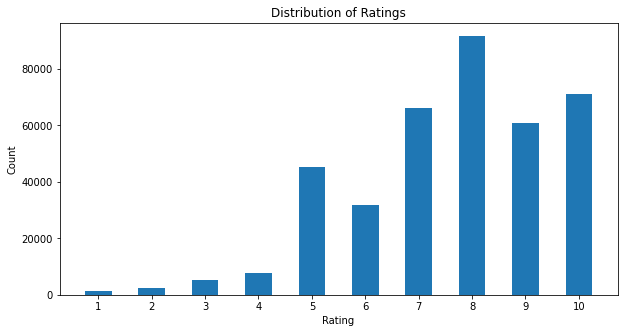

In [9]:
! pip install matplotlib
import matplotlib.pyplot as plt

x = ratings_df.groupby('Rating')['ISBN'].count().reset_index(name="count")
print(x)

# plt.hist(ratings_df.groupby("Rating").count()[['ISBN']], )
fig, ax = plt.subplots()

ax.bar(x['Rating'], x['count'], width=.5)
ax.set_title('Distribution of Ratings')
ax.set_ylabel('Count')
ax.set_xlabel('Rating')
ax.set_xticks(x['Rating'])
fig.set_size_inches(10,5)

plt.show()

## Partition the data into training and validation

After partitioning the data, save the data in Parquet format.

In [10]:
ratings = ratings_df.sample(len(ratings_df), replace=False)
validation_count = int(len(ratings) * 0.33)

train = ratings[:-validation_count]
valid = ratings[-validation_count:]

train = merlin.io.Dataset(train)
valid = merlin.io.Dataset(valid)
books = merlin.io.Dataset(books_df)

# train.to_parquet(data_dir / "train.parquet")
# valid.to_parquet(data_dir / "valid.parquet")
# books.to_parquet(data_dir / "books.parquet")


/home/local/repos/NVTabular/.venv/lib/python3.8/site-packages/merlin/io/dataset.py:252: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


## Attempting to understand how to use NVT's Ops

In the discussion at <https://nvidia-merlin.github.io/NVTabular/main/examples/getting-started-movielens/02-ETL-with-NVTabular.html>,
I'm a little disoriented:

* Before the "Defining our Preprocessing Pipeline", there is a `head()` of the movies data.
That is good because it reinforces my understanding of the data.

* In the "Defining..." section, the **Example** is generic--`features = [ column_name, ... ]...`.
This is slightly disorienting and I'd like to consider if using the same variable names from the data sample could work.

* Right after the generic example, `CATEGORICAL_COLUMNS` and `LABEL_COLUMNS` are defined--and tie to the data sample, which is good, but I'm lost in what we're joining with the `JoinExternal` Op and why `joined.graph` has two tables with inputs of `userID, movieID` and outputs the same two columns.  I'm missing something.

My instinct is that the Movielens example is growing stale.  I switched to looking at <https://nvidia-merlin.github.io/Merlin/main/examples/Building-and-deploying-multi-stage-RecSys/01-Building-Recommender-Systems-with-Merlin.html> for inspiration.

In [11]:
from nvtabular.ops import (
    Categorify,
    Dropna,
    LambdaOp,
    TagAsUserID,
    TagAsItemID,
    TagAsItemFeatures,
    TagAsUserFeatures,
    AddMetadata,
    Filter,
    Rename,
    JoinExternal,
)

from nvtabular import ColumnGroup

from merlin.schema.tags import Tags

from merlin.io.dataset import Dataset

In [12]:
display(train.head())
display(books.head())

,User_ID,ISBN,Rating
86890,51742,0449215024,8
337836,216012,0595097944,7
177514,106028,158827523X,8
166990,99955,1569245134,8
394392,252055,1560255021,7


,ISBN,Title,Author,Year_Of_Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


We need a way to join the training data and the books data on the common column, ISBN.
The `JoinExternal` Op can perform the join.

(The graph that I get does not look like the graph at <https://nvidia-merlin.github.io/NVTabular/main/examples/getting-started-movielens/02-ETL-with-NVTabular.html#defining-our-preprocessing-pipeline>.
I do not know why, but my only suspicion is that the graph does not know about the `train` data.)

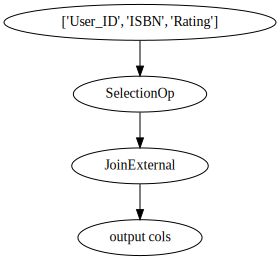

In [13]:

joined = list(train.to_ddf().columns) >> JoinExternal(books, on=["ISBN"])

joined.graph

Perform some data preparation:

* Materialize the join of the books dataset with the training dataset so that we can access the title, author, publisher, and so on.
* In addition, add an `ISBN_onehotencoded` column. We need the column because the `ISBN` column is a string and we need an integer value for the item ID so we can perform modeling.

In [14]:
item_id = ["ISBN"] >> Rename(postfix="_onehotencoded") >> Categorify() >> TagAsItemID()

prep_xform = nvt.Workflow(joined + item_id).fit(train)
train_prepped = prep_xform.transform(train)

train_prepped.head()

/home/local/repos/NVTabular/.venv/lib/python3.8/site-packages/merlin/io/dataset.py:408: UserWarning: Changing an NVTabular Dataset to CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/home/local/repos/NVTabular/.venv/lib/python3.8/site-packages/merlin/io/dataset.py:252: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


,User_ID,ISBN,Rating,Title,Author,Year_Of_Publication,Publisher,ISBN_onehotencoded
0,51742,0449215024,8,Sacred and Profane (Peter Decker & Rina Lazaru...,Faye Kellerman,1997,Fawcett Books,3519
1,216012,0595097944,7,All for a Good Cause,R. Barri Flowers,2000,iUniverse,96709
2,106028,158827523X,8,Anabasis,Xenophon,2001,IndyPublish.com,52025
3,99955,1569245134,8,Party of One: The Loners' Manifesto,Anneli S. Rufus,2003,Marlowe & Company,9178
4,252055,1560255021,7,Dreaming War: Blood for Oil and the Cheney-Bus...,Gore Vidal,2003,Nation Books,7274


Perform some data transformation and feature engineering with the Ops available from NVTabular.

In [15]:
user_id = ["User_ID"] >> Categorify() >> TagAsUserID()
# item_id = ["ISBN"] >> Rename(postfix="_onehot") >> Categorify() >> TagAsItemID()

item_features = (
    joined[["Title", "Author", "Year_Of_Publication", "Publisher"]] >> Categorify() >> TagAsItemFeatures()
)

target = ColumnGroup(["Rating"]) >> LambdaOp(lambda col: (col > 7).astype(np.int8)) >> Rename(name="good_or_bad") >> AddMetadata(tags=[Tags.BINARY_CLASSIFICATION, "target"])

For play, view the `LambdaOp` and `Rename` Ops in action on the `Rating` column from the `train` dataset:

In [16]:
print("The data type of target: ", type(target))
workflow = nvt.Workflow(target)
workflow.fit(train)
display(workflow.transform(train).head())

The data type of target:  <class 'nvtabular.workflow.node.WorkflowNode'>


/home/local/repos/NVTabular/.venv/lib/python3.8/site-packages/merlin/io/dataset.py:252: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


,good_or_bad
86890,1
337836,0
177514,1
166990,1
394392,0


Now, run the workflow on the data:

* Define an `output` variable that combines the workflow nodes.  These workflow nodes are the Ops that perform the feature engineering.
* For fun, display the workflow as a graph with graphviz.
* Define a new `workflow` variable that can perform the feature engineering.
* Fit and transform the workflow on the training data and then display the first few rows.

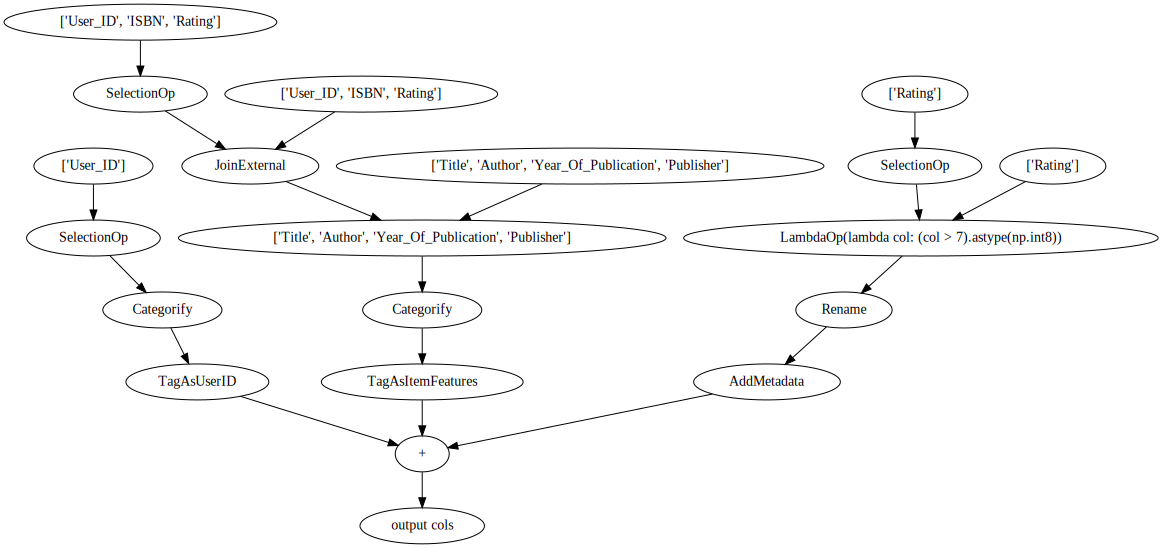

In [17]:
output = item_features + user_id + target

output.graph

For demonstration purposes, specify some columns manually so that we can view the transformed values alongside the original values.

In [18]:
workflow = nvt.Workflow(output + ['Rating', 'ISBN', 'ISBN_onehotencoded'])
workflow.fit(train_prepped)

/home/local/repos/NVTabular/.venv/lib/python3.8/site-packages/merlin/io/dataset.py:252: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [22]:
training_data = workflow.transform(train_prepped)

display(training_data.head(n=20))

/home/local/repos/NVTabular/.venv/lib/python3.8/site-packages/merlin/io/dataset.py:252: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


,Title,Author,Year_Of_Publication,Publisher,User_ID,good_or_bad,Rating,ISBN,ISBN_onehotencoded
0,1678,64,7,19,829,1,8,0449215024,3519
1,71967,7270,5,484,43,0,7,0595097944,96709
2,73941,22265,2,1024,7790,1,8,158827523X,52025
3,10577,9020,3,611,450,1,8,1569245134,9178
4,8527,1187,3,1273,21322,0,7,1560255021,7274
5,74798,103,29,18,20942,1,8,0671227017,92444
6,77147,22184,2,5128,52151,1,10,0963056611,53082
7,13155,11258,1,3,2,1,9,0425186180,106688
8,4064,655,8,6,606,0,7,0553568914,3810
9,19118,13167,4,235,44531,0,4,0671018027,27716


In [23]:
training_data.to_parquet(data_dir / "training_data.parquet")

Apply the same data preparation to the validation data:

In [28]:
valid_prepped = prep_xform.transform(valid)
validation_data = workflow.transform(valid_prepped)

display(valid_prepped.head())
display(validation_data.head())

validation_data.to_parquet(data_dir / "validation_data.parquet")

/home/local/repos/NVTabular/.venv/lib/python3.8/site-packages/merlin/io/dataset.py:252: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


,User_ID,ISBN,Rating,Title,Author,Year_Of_Publication,Publisher,ISBN_onehotencoded
0,153662,0451180208,9,Material Witness,Robert K. Tanenbaum,1994,Signet Book,15029
1,205774,0451204891,5,The Hearing,John Lescroart,2002,Signet Book,1501
2,95359,0525945121,5,Chang and Eng,Darin Strauss,2000,Dutton Books,2453
3,223296,0609610597,10,The Shelters of Stone (Earth's Children Series...,JEAN M. AUEL,2002,Crown,442
4,154469,0553561618,10,Dark Paradise,TAMI HOAG,1994,Bantam,723


,Title,Author,Year_Of_Publication,Publisher,User_ID,good_or_bad,Rating,ISBN,ISBN_onehotencoded
0,14351,532,10,8,4,1,9,0451180208,15029
1,1119,1002,1,8,24438,0,5,0451204891,1501
2,2721,1770,5,75,15,0,5,0525945121,2453
3,567,181,1,258,0,1,10,0609610597,442
4,843,97,10,5,845,1,10,0553561618,723
